# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [191]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures

In [192]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


## Read data 

In [193]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

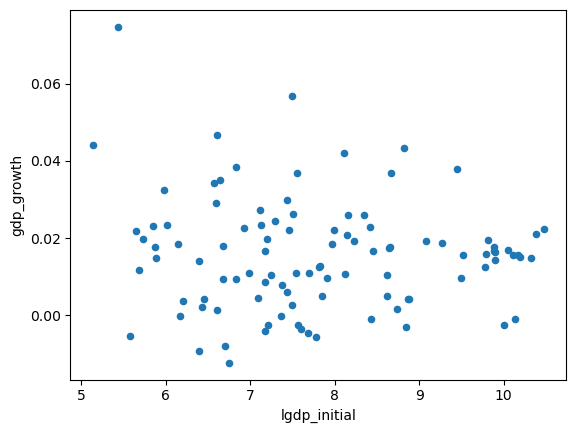

In [194]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

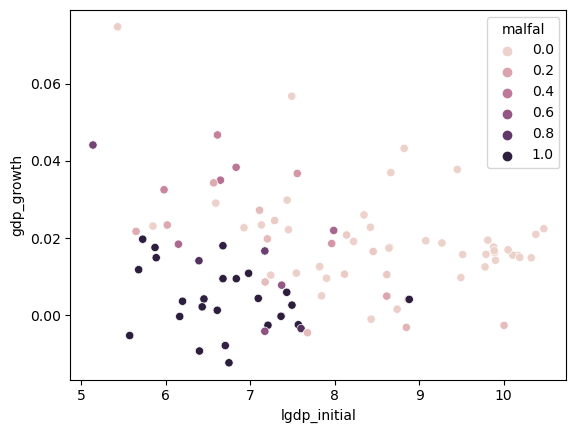

In [195]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [196]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage'] # Diseases
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

# Variables we use
# Institutions, geography, religion, danger (health), resources, education, pop growth

# Code job for Lucas
# Use variables choosen
# Graph Lasso with different penalty levels
# Lasso with CV, BRT and BCCH at difference penalty levels like in week 4 exercise
# Use BRT and BCCH optimal penalty level and use dobbel lasso and post dobbelt lasso.



In [197]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

# Simple OLS

In [198]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'gdp_pc_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','gdp_pc_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 1.59145681e+00]
 [-3.92054026e-06]]


# Adding more controls

In [199]:
vs = vv_all['geography'] + vv_all['religion']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y
#print(betas)

In [200]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.52% growth per year


,β
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204
suitgini,-0.771


In [201]:
from datetime import datetime

# ---- configuration ----
id_col = 'code'
cols_to_check = ['gdp_growth', 'gdp_pc_initial']
continent_cols = ['africa', 'americas', 'asia', 'europe', 'oceania'] # Europa is irrelevant, as it is reference dummy
report_path = 'data_cleaning_report.txt'

# ---- identify rows to remove / keep ----
missing_mask = dat[cols_to_check].isnull().any(axis=1)
removed = dat.loc[missing_mask].copy()
kept = dat.loc[~missing_mask].copy()

# ---- helper: decode continent from dummies ----
def resolve_continent(row):
    active = [c for c in continent_cols if row.get(c, 0) == 1]
    if len(active) == 1:
        return active[0].capitalize()
    elif len(active) == 0:
        return "Unknown"
    else:
        return "Multiple"

removed['continent'] = removed.apply(resolve_continent, axis=1)
kept['continent']   = kept.apply(resolve_continent, axis=1)

# (optional) which GDP columns were missing for removed
removed['missing_in'] = dat.loc[missing_mask, cols_to_check].isnull().apply(
    lambda r: ', '.join([c for c, v in r.items() if v]), axis=1
)

# ---- completeness table for kept countries, for "other variables" ----
exclude = set([id_col] + cols_to_check + continent_cols)
other_vars = [c for c in dat.columns if c not in exclude]

non_missing_counts = kept[other_vars].notnull().sum().rename('non_missing')
missing_counts = (len(kept) - non_missing_counts).rename('missing')
completeness = ((non_missing_counts / len(kept)) * 100).round(1).rename('complete_%')

completeness_table = pd.concat([non_missing_counts, missing_counts, completeness], axis=1)\
                       .sort_index()

# ---- build the report text ----
lines = []
lines.append("DATA CLEANING REPORT")
lines.append(f"Generated: {datetime.now().isoformat(timespec='seconds')}")
lines.append("")
lines.append(f"Total rows before cleaning: {len(dat)}")
lines.append(f"Rows removed (missing in {', '.join(cols_to_check)}): {len(removed)}")
lines.append(f"Rows kept (complete in those columns): {len(kept)}")
lines.append("")

# Removed list
lines.append("=== REMOVED COUNTRIES ===")
if removed.empty:
    lines.append("(none)")
else:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        lines.append(removed[[id_col, 'continent', 'missing_in']].sort_values([ 'continent', id_col]).to_string(index=False))
lines.append("")

# Kept list
lines.append("=== KEPT COUNTRIES ===")
if kept.empty:
    lines.append("(none)")
else:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        lines.append(kept[[id_col, 'continent']].sort_values([ 'continent', id_col]).to_string(index=False))
lines.append("")

# Summary by continent
lines.append("=== SUMMARY BY CONTINENT ===")
summary = pd.DataFrame({
    'removed': removed['continent'].value_counts(),
    'kept': kept['continent'].value_counts()
}).fillna(0).astype(int).sort_index()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    lines.append(summary.to_string())
lines.append("")

# Completeness table
lines.append("=== COMPLETENESS FOR KEPT COUNTRIES (OTHER VARIABLES) ===")
lines.append(f"(Variables excluded from this table: {', '.join(sorted(exclude))})")
if len(other_vars) == 0:
    lines.append("(no other variables found)")
else:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        lines.append(completeness_table.to_string())

# ---- write file ----
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("\n".join(lines))

print(f"Report written to: {report_path}")


Report written to: data_cleaning_report.txt


# Testcode from Week 4 Lasso

In [202]:
# Keep only interesting variables
# Combining all variables we want to use
vs = []
vs.extend(vv_all['institutions'])  # Institutional variables
vs.extend(vv_all['geography'])     # Geographic variables
vs.extend(vv_all['religion'])      # Religious variables
vs.extend(vv_all['danger'])        # Health/disease variables
vs.extend(vv_all['resources'])     # Natural resource variables
vs.extend(vv_educ)                 # Education variables
vs.extend(['pop_growth'])          # Population growth
vs.extend(['lgdp_initial'])        # Log gdp initial

# Add our main variables of interest
main_var = ['gdp_pc_initial']
all_vars = main_var + vs

# Check which variables have missing values before filtering
print("Missing values before filtering:")
print(dat[all_vars].isnull().sum())

# Only remove countries with missing values in our chosen variables
complete_cases = dat[all_vars].notnull().all(axis=1)
kept = dat[complete_cases].copy()

# Verify no missing values remain in our variables of interest
print("\nMissing values after filtering:")
print(kept[all_vars].isnull().sum())


# Prepare data for Lasso
y = kept['gdp_growth'].values.reshape((-1,1)) * 100.0  # Convert to percentage
X = kept[vs].values     # All variables except the dependent and gdp intitial variable
d = kept['gdp_pc_initial'].values # Our beta variable
Z = PolynomialFeatures(2, include_bias=False).fit_transform(X)

# Display number of regressors
print("The number of regressors in Z is {}".format(Z.shape[1]))


Xnames = kept[vs].columns

# Print dimensions of our matrices
print(f'X matrix shape: {X.shape}')
print(f'y vector shape: {y.shape}')

Missing values before filtering:
gdp_pc_initial    105
marketref          78
dem                59
demCGV             64
demBMR             60
demreg             31
tropicar           55
distr              55
distcr             55
distc              55
suitavg            59
temp               30
suitgini           54
elevavg            30
elevstd            53
kgatr              54
precip             30
area                6
abslat              9
cenlong             6
area_ar            18
rough              30
landlock           51
africa              6
asia                6
oceania             6
americas            6
pprotest           13
pcatholic          10
pmuslim            10
yellow             51
malfal             50
uvdamage            7
oilres             60
goldm              55
iron               55
silv               55
zinc               55
ls_bl              71
lh_bl              71
pop_growth         16
lgdp_initial      105
dtype: int64

Missing values after filterin

# Check rank and collinearity

In [203]:
# Combine X (controls) and d (gdp_pc_initial) and re-check collinearity
d_col = np.asarray(d).reshape(-1, 1)
X_d = np.hstack([X, d_col])

# Prepare names: try several likely name sources that exist in the notebook
if 'var_names_no_dummy' in globals() and 'var_names_dummy' in globals():
    var_names = list(var_names_no_dummy) + list(var_names_dummy)
elif 'var_names' in globals():
    var_names = list(var_names)
elif 'Xnames' in globals():
    var_names = list(Xnames)
else:
    # fallback generic names
    var_names = [f'var_{i}' for i in range(X.shape[1])]

names_d = var_names[:]  # copy existing names aligned with X
if 'gdp_pc_initial' not in names_d:
    names_d = names_d + ['gdp_pc_initial']

# Trim/extend names to match X_d columns
if len(names_d) != X_d.shape[1]:
    if len(names_d) > X_d.shape[1]:
        names_d = names_d[:X_d.shape[1]]
    else:
        names_d += [f'var_{i}' for i in range(len(names_d), X_d.shape[1])]

# Set threshold if not already defined in the notebook
threshold = globals().get('threshold', 0.8)

# Correlation matrix (includes d)
corr_matrix = pd.DataFrame(X_d, columns=names_d).corr()
print("Top highly correlated pairs (abs(corr) > threshold):")
high_corr = np.where(np.abs(corr_matrix) > threshold)
pairs = [(names_d[i], names_d[j], corr_matrix.iloc[i, j]) for i, j in zip(*high_corr) if i < j]
for a, b, c in pairs:
    print(f"{a} - {b}: {c:.3f}")

# Condition number for combined matrix
cond = np.linalg.cond(X_d)
print(f"Condition number (X with d): {cond:.2e}")

# VIF: exclude any constant column when computing VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_for_vif = X_d.copy()
vif_names = names_d.copy()
if 'constant' in vif_names:
    ci = vif_names.index('constant')
    X_for_vif = np.delete(X_for_vif, ci, axis=1)
    vif_names.pop(ci)

vif_df = pd.DataFrame({
    'Variable': vif_names,
    'VIF': [variance_inflation_factor(X_for_vif, i) for i in range(X_for_vif.shape[1])]
}).sort_values('VIF', ascending=False)

print("\nVIF including lgdp_initial:")
print(vif_df)


Top highly correlated pairs (abs(corr) > threshold):
var_4 - var_5: 0.941
var_4 - var_6: 0.941
var_5 - var_6: 1.000
var_8 - var_13: 0.830
var_8 - var_31: -0.891
var_8 - var_3: 0.843
var_10 - var_11: 0.897
var_12 - var_14: -0.837
var_13 - var_31: -0.893
var_13 - var_3: 0.906
var_24 - var_19: 0.802
var_31 - var_3: -0.954
var_2 - var_35: 0.833
var_40 - var_41: 0.882
Condition number (X with d): 9.70e+16

VIF including lgdp_initial:
          Variable          VIF
2            var_5          inf
3            var_6          inf
31           var_3  1325.581336
10          var_13   713.595818
40          var_40   319.802718
11          var_14    66.643538
12          var_15    60.928518
17          var_31    57.403103
8           var_11    55.230584
5            var_8    53.285248
9           var_12    53.032770
23          var_27    51.444560
22          var_23    50.254024
18           var_1    48.583535
41          var_41    46.100897
39          var_39    45.813520
25          var_25    4

c:\Users\lucas\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


# Remove perfect multicollinearity

In [204]:
# Drop unwanted variables from the kept DataFrame and update related arrays/lists
cols_to_drop = ['uvdamage', 'demCGV', 'demBMR']
# We drop these, as they are very correlated with other variables, leading to multicollinearity issues.

# Drop from kept if present
for c in cols_to_drop:
    if c in kept.columns:
        kept.drop(columns=c, inplace=True)

# Remove from vs (controls) if present
vs = [v for v in vs if v not in cols_to_drop]

# Rebuild X, d, Z and Xnames consistent with the dropped variables
X = kept[vs].values
d = kept['gdp_pc_initial'].values
Z = PolynomialFeatures(2, include_bias=False).fit_transform(X)
Xnames = list(kept[vs].columns)

# Update variable name lists if they exist in the namespace
for name in ('variable_names', 'var_names', 'var_names_reduced', 'vars_no_const'):
    if name in globals():
        globals()[name] = [v for v in globals()[name] if v not in cols_to_drop]

print("Dropped columns:", [c for c in cols_to_drop if c not in kept.columns])
print("X shape:", X.shape)
print("Z shape:", Z.shape)
print("First X names:", Xnames[:10])

Dropped columns: ['uvdamage', 'demCGV', 'demBMR']
X shape: (74, 38)
Z shape: (74, 779)
First X names: ['marketref', 'dem', 'demreg', 'tropicar', 'distr', 'distcr', 'distc', 'suitavg', 'temp', 'suitgini']


# Standarize all the variables

We remove dummys before standarize anad add them after

In [205]:
# --- Split into X_dummy and X_no_dummy ---

if isinstance(X, pd.DataFrame):
    # A column is a dummy if (ignoring NaN) it only contains 0/1
    is_dummy = X.apply(lambda s: set(pd.unique(s.dropna())).issubset({0, 1}))
    X_dummy = X.loc[:, is_dummy.values]
    X_no_dummy = X.loc[:, ~is_dummy.values]

    # Optional: names
    var_names_dummy = X_dummy.columns.tolist()
    var_names_no_dummy = X_no_dummy.columns.tolist()

else:
    # Treat X as NumPy array
    X = np.asarray(X)

    def col_is_dummy(col):
        # keep numeric columns; ignore NaNs
        if np.issubdtype(col.dtype, np.number):
            col = col[~np.isnan(col)]
        uniq = np.unique(col)
        # only 0/1 (at most two unique values)
        return np.isin(uniq, [0, 1]).all() and uniq.size <= 2

    is_dummy_mask = np.array([col_is_dummy(X[:, j]) for j in range(X.shape[1])])

    X_dummy = X[:, is_dummy_mask]
    X_no_dummy = X[:, ~is_dummy_mask]

    # Optional: names if you have them
    if 'var_names' in globals():
        idx_dummy = np.where(is_dummy_mask)[0].tolist()
        idx_no_dummy = np.where(~is_dummy_mask)[0].tolist()
        # Safely map indices to names: only if var_names length matches number of columns.
        if len(var_names) == X.shape[1]:
            var_names_dummy = [var_names[i] for i in idx_dummy]
            var_names_no_dummy = [var_names[i] for i in idx_no_dummy]
        else:
            # Fallback to generic names to avoid IndexError
            var_names_dummy = [f'var_{i}' for i in idx_dummy]
            var_names_no_dummy = [f'var_{i}' for i in idx_no_dummy]
    else:
        # No var_names available: generate generic names
        idx_dummy = np.where(is_dummy_mask)[0].tolist()
        idx_no_dummy = np.where(~is_dummy_mask)[0].tolist()
        var_names_dummy = [f'var_{i}' for i in idx_dummy]
        var_names_no_dummy = [f'var_{i}' for i in idx_no_dummy]

# Quick sanity check (optional):
# ensure X_dummy / X_no_dummy are 2D for consistent shape access
X_dummy = np.atleast_2d(X_dummy) if X_dummy.size != 0 else X_dummy.reshape(X.shape[0], 0)
X_no_dummy = np.atleast_2d(X_no_dummy) if X_no_dummy.size != 0 else X_no_dummy.reshape(X.shape[0], 0)

print(f"Dummy columns: {X_dummy.shape[1]} | Non-dummy columns: {X_no_dummy.shape[1]}")


Dummy columns: 7 | Non-dummy columns: 31


We also need to remove variables which have no variance, as they cannot be standarized and also are useless as control

In [206]:
# --- Find zero-variance columns (incl. all-NaN) ---

if isinstance(X, pd.DataFrame):
    def is_zero_variance(s: pd.Series) -> bool:
        s2 = s.dropna()
        # zero variance if 0 or 1 unique non-NaN values
        return s2.nunique() <= 1

    zero_var_mask = X.apply(is_zero_variance).values
    zero_var_cols = X.columns[zero_var_mask].tolist()
    zero_var_idx  = np.where(zero_var_mask)[0].tolist()

    print(f"Zero-variance columns ({len(zero_var_cols)}): {zero_var_cols}")

else:
    # Assume numeric NumPy array
    X = np.asarray(X)
    # nanstd==0 catches constant columns; all-NaN columns also flagged
    nz = np.nanstd(X, axis=0)
    zero_var_mask = (nz == 0) | np.isnan(X).all(axis=0)

    zero_var_idx = np.where(zero_var_mask)[0].tolist()
    print(f"Zero-variance column indices ({len(zero_var_idx)}): {zero_var_idx}")

    # If you keep names in var_names, list them:
    if 'var_names' in globals():
        zero_var_cols = [var_names[i] for i in zero_var_idx]
        print(f"Zero-variance columns: {zero_var_cols}")

Zero-variance column indices (0): []
Zero-variance columns: []


In [207]:
def standardize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    X_stan = (X - mu)/sigma
    return X_stan

X_stan = standardize(X_no_dummy)
Z_stan = standardize(Z)
d_stan = standardize(d)

print("Shape of standardized X (without dummy):", X_stan.shape)
print("Shape of standardized Z:", Z_stan.shape)
print("Shape of standardized d:", d_stan.shape)
print("Shape of standardized X (only dummy):", X_dummy.shape)

# Make stan and dummy together
X = np.column_stack([X_stan, X_dummy])

print("Shape of standardized X:", X.shape)

Shape of standardized X (without dummy): (74, 31)
Shape of standardized Z: (74, 779)
Shape of standardized d: (74,)
Shape of standardized X (only dummy): (74, 7)
Shape of standardized X: (74, 38)


C:\Users\lucas\AppData\Local\Temp\ipykernel_5628\1515399332.py:4: RuntimeWarning: invalid value encountered in divide
  X_stan = (X - mu)/sigma


In [208]:
# pick the main DataFrame and columns used in your notebook
main_df = kept          # or: kept
code_col = "code"
target_col = "gdp_growth"

# countries with any missing y
codes_missing = (main_df.loc[main_df[target_col].isna(), code_col]
                 .dropna().unique().tolist())
print(f"Countries with missing {target_col}:", codes_missing)

# counts per country
counts = (main_df.loc[main_df[target_col].isna(), [code_col]]
          .value_counts().sort_values(ascending=False))
print("\nMissing counts per country:")
print(counts)



Countries with missing gdp_growth: ['JPN', 'VEN']

Missing counts per country:
code
JPN     1
VEN     1
Name: count, dtype: int64


In [209]:
# --- 1) Ensure array types ---
X = np.asarray(X, dtype=float)
y = np.asarray(y, dtype=float).ravel()

# --- 2) Build a clean-row mask ---
mask_y = np.isfinite(y)                      # drop NaN/inf in y (required)
mask_X = np.isfinite(X).all(axis=1)          # optional: keep only rows with finite X
mask = mask_y & mask_X

if mask.sum() < len(y):
    print(f"Dropping {len(y) - mask.sum()} rows due to NaNs/Infs "
          f"(y dropped: {(~mask_y).sum()}, X dropped: {(~mask_X).sum()}).")

X = X[mask, :]
y = y[mask]

# --- 3) (Optional) sanity checks ---
assert np.isfinite(y).all()
assert np.isfinite(X).all()

# --- 4) Lasso path over your penalty grid ---
penalty_grid = np.geomspace(0.01, 80000, num=500)
coefs = []
for lamb in penalty_grid:
    fit = Lasso(alpha=lamb, fit_intercept=True, max_iter=10000).fit(X_clean, y_clean)
    coefs.append(fit.coef_)


Dropping 2 rows due to NaNs/Infs (y dropped: 2, X dropped: 0).


In [210]:
def plot_lasso_path(penalty_grid, coefs, legends=None, vlines: dict = None):
    """
    Plots the coefficients as a function of the penalty parameter for Lasso regression.

    Behaviors changed: sets maximum displayed penalty to 1e1 and omits the variable-name legend.
    """
    # Create figure with specific size
    plt.figure(figsize=(8, 5))

    # Ensure coefficients are a numpy array of shape (n_penalties, n_vars)
    coefs_array = np.array(coefs)
    if coefs_array.ndim == 1:
        coefs_array = coefs_array.reshape(-1, 1)

    # Plot each coefficient path (no legend to avoid clutter)
    for j in range(coefs_array.shape[1]):
        plt.plot(penalty_grid, coefs_array[:, j], linewidth=1)

    # Log scale for x-axis
    plt.xscale('log')

    # Set x-axis limits: min penalty to 1e1
    xmin = float(np.min(penalty_grid))
    xmax = 1e0
    plt.xlim(left=xmin, right=xmax)

    # Labels and title (use proper TeX strings)
    plt.xlabel(r"Penalty, $\lambda$")
    plt.ylabel(r"Estimates, $\widehat{\beta}_j(\lambda)$")
    plt.title('Lasso Path for selected variables')

    # Add vertical lines if specified (still shown)
    if vlines is not None:
        for name, penalty in vlines.items():
            if penalty <= xmax:
                plt.axvline(x=penalty, linestyle='--', color='grey', alpha=0.6)
                plt.text(penalty,-80000,name,rotation=90)

    # Make layout compact
    plt.tight_layout()

    # Show plot
    plt.show()
    plt.close()

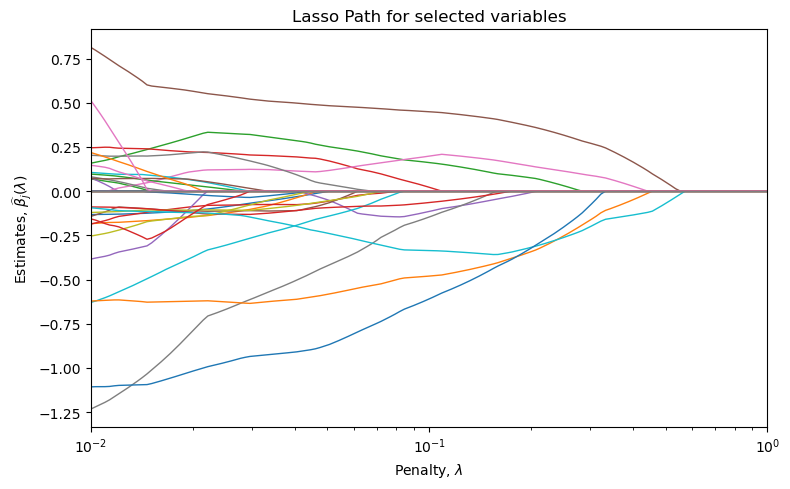

In [211]:
# Plot lasso path
plot_lasso_path(penalty_grid, coefs, Xnames)

In [212]:
# Convert coefficients to array
coefs_array = np.array(coefs)
if coefs_array.ndim == 1:
    coefs_array = coefs_array.reshape(-1, 1)

n_lams, n_vars = coefs_array.shape

# Determine variable names (prefer variable_names, then Xnames)
try:
    names = list(variable_names)
except NameError:
    try:
        names = list(Xnames)
    except NameError:
        names = [f'var_{i}' for i in range(n_vars)]

# Safety: if names length mismatches, generate generic names
if len(names) != n_vars:
    names = [f'var_{i}' for i in range(n_vars)]

tol = 1e-8 # Right side max on graph
persistence = np.zeros(n_vars)
for j in range(n_vars):
    idx = np.where(np.abs(coefs_array[:, j]) > tol)[0]
    if idx.size == 0:
        persistence[j] = 0.0
    else:
        persistence[j] = float(np.max(penalty_grid[idx]))

# Exclude constant from ranking if present
const_idx = None
if 'constant' in names:
    const_idx = names.index('constant')

items = [(names[j], persistence[j]) for j in range(n_vars) if j != const_idx]
items_sorted = sorted(items, key=lambda x: x[1], reverse=True)

topk = 10
print(f"Top {topk} variables by maximum penalty where they remain non-zero (lambda_max):\n")
for name, lam in items_sorted[:topk]:
    print(f"{name:25s}  lambda_max = {lam:.3e}")

# Summary
never_selected = [names[j] for j in range(n_vars) if persistence[j] == 0 and j != const_idx]
print(f"\nNumber never selected: {len(never_selected)}")
if len(never_selected) <= 30:
    print("Never selected:", never_selected)
else:
    print("Never selected (first 30):", never_selected[:30])

Top 10 variables by maximum penalty where they remain non-zero (lambda_max):

oilres                     lambda_max = 5.534e-01
abslat                     lambda_max = 5.361e-01
asia                       lambda_max = 4.428e-01
cenlong                    lambda_max = 4.289e-01
elevavg                    lambda_max = 3.324e-01
goldm                      lambda_max = 3.220e-01
kgatr                      lambda_max = 2.746e-01
distr                      lambda_max = 2.062e-01
americas                   lambda_max = 1.703e-01
suitavg                    lambda_max = 1.548e-01

Number never selected: 8
Never selected: ['distc', 'temp', 'elevstd', 'pprotest', 'silv', 'ls_bl', 'lh_bl', 'lgdp_initial']


# Cross validation

In [213]:
# Estimate the model using LassoCV
fit_CV = LassoCV(cv=5, alphas=penalty_grid).fit(X,y)

# Investigate the penalty
penalty_CV = fit_CV.alpha_ 
print('Penalty_CV: ', round(penalty_CV,4))

# Investigate the coefficients
coeff_CV = fit_CV.coef_
print('Coefficients: ', np.round(coeff_CV))

# Investigate the selected variables
selected_variables = (coeff_CV != 0)

# Ensure selected_variables matches the length of Xnames
if len(selected_variables) != len(Xnames):
	selected_variables = np.pad(selected_variables, (0, len(Xnames) - len(selected_variables)), 'constant')

print('Selected variables: ', np.array(Xnames)[selected_variables].tolist()) 

Penalty_CV:  0.0721
Coefficients:  [-0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.
 -0.  0. -0. -1. -0. -0. -0. -0.  0.  0. -0. -0. -1.  0. -0. -0.  0. -0.
  0. -0.]
Selected variables:  ['tropicar', 'distr', 'suitavg', 'suitgini', 'kgatr', 'precip', 'abslat', 'cenlong', 'rough', 'asia', 'americas', 'oilres', 'goldm']


# Mean squared error for a given penalty level


In [214]:
# Retrieve penalty and MSE
penalties_CV = fit_CV.alphas_
MSE_CV = np.mean(fit_CV.mse_path_, axis=1)

In [215]:
# ...existing code...
def plot_MSE_path(penalty_grid, MSE):
    """
    Plots the mean squared error (MSE) as a function of the penalty parameter.

    Parameters:
    penalty_grid (array-like): The penalty parameter values.
    MSE (array-like): The corresponding MSE values.
    """
    # Initiate figure 
    fig, ax = plt.subplots()

    # Ensure inputs are numpy arrays
    penalty_grid = np.asarray(penalty_grid)
    MSE = np.asarray(MSE)

    # Plot MSE as a function of the penalty parameter
    ax.plot(penalty_grid, MSE, marker='o', markersize=3, linewidth=1)

    # Set log scale for the x-axis
    ax.set_xscale('log')
    
    # Plot minimum MSE
    min_MSE_idx = np.argmin(MSE)
    min_MSE_penalty = penalty_grid[min_MSE_idx]
    ax.axvline(x=min_MSE_penalty, linestyle='--', color='grey')

    # Place label inside the axes using axis-transform (avoids huge data-coord y)
    ax.text(min_MSE_penalty, 0.95, "Minimum MSE", rotation=90,
            transform=ax.get_xaxis_transform(), va='top', ha='right', color='grey')

    # Add labels
    ax.set_xlabel('Penalty, $\\lambda$')
    ax.set_ylabel('Mean squared error')
    ax.set_title('Mean squared error')

    # Tight layout and show
    fig.tight_layout()
    plt.show()
    plt.close()
# ...existing code...

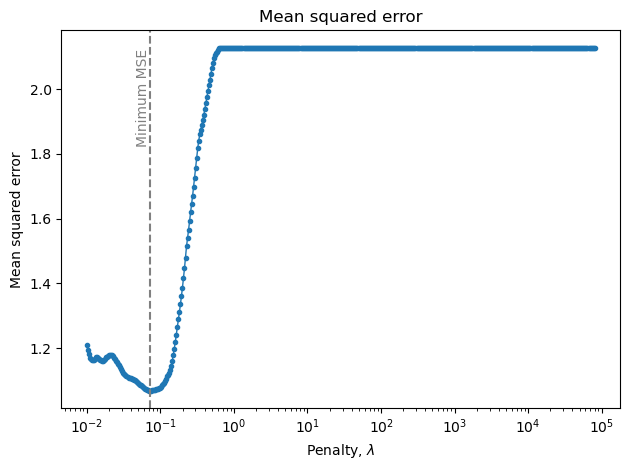

In [216]:
# Plot MSE as a function of the penalty parameter
plot_MSE_path(penalties_CV, MSE_CV)